In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

## Baseline

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [4]:
submission = pd.read_csv('sample_submission.csv')

In [5]:
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def create_lag_feats(data, lags, cols):
    
    lag_cols = []
    temp = data.copy()
    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            temp['Target1'] = temp['TARGET']
            temp['Target2'] = temp['TARGET'].shift(-48).fillna(method='ffill')  
            lag_cols.append(col + '_lag_%s'%lag)

    return temp, lag_cols
    

def preprocess_data(data, target_lags=[48], weather_lags=[48], is_train=True):
    
    temp = data.copy()

    if is_train==True:          
    
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T'])
     
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2 + ['Target1', 'Target2']].dropna()

    elif is_train==False:    
        
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T'])
                              
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2].dropna()


df_train = preprocess_data(train, target_lags=[48], weather_lags=[48], is_train=True)
df_train.iloc[:48]

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1,Target2
48,0,0.000000,0.0,0.0,1.5,69.08,-12.0,0.000000,0.000000
49,0,0.000000,0.0,0.0,1.5,69.06,-12.0,0.000000,0.000000
50,1,0.000000,0.0,0.0,1.6,71.78,-12.0,0.000000,0.000000
51,1,0.000000,0.0,0.0,1.6,71.75,-12.0,0.000000,0.000000
52,2,0.000000,0.0,0.0,1.6,75.20,-12.0,0.000000,0.000000
53,2,0.000000,0.0,0.0,1.5,69.29,-11.0,0.000000,0.000000
54,3,0.000000,0.0,0.0,1.5,72.56,-11.0,0.000000,0.000000
55,3,0.000000,0.0,0.0,1.4,72.55,-11.0,0.000000,0.000000
56,4,0.000000,0.0,0.0,1.3,74.62,-11.0,0.000000,0.000000
57,4,0.000000,0.0,0.0,1.3,74.61,-11.0,0.000000,0.000000


In [7]:
train.iloc[48:96]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
48,1,0,0,0,0,1.6,90.66,-10,0.000000
49,1,0,30,0,0,1.6,90.68,-10,0.000000
50,1,1,0,0,0,1.6,88.11,-11,0.000000
51,1,1,30,0,0,1.6,88.11,-11,0.000000
52,1,2,0,0,0,1.6,90.85,-11,0.000000
53,1,2,30,0,0,1.6,90.84,-11,0.000000
54,1,3,0,0,0,1.7,93.78,-12,0.000000
55,1,3,30,0,0,1.7,93.77,-12,0.000000
56,1,4,0,0,0,1.7,90.46,-12,0.000000
57,1,4,30,0,0,1.6,90.46,-12,0.000000


In [8]:
train.iloc[48+48:96+48]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
96,2,0,0,0,0,2.2,73.80,-8,0.000000
97,2,0,30,0,0,2.1,68.20,-8,0.000000
98,2,1,0,0,0,2.1,69.06,-8,0.000000
99,2,1,30,0,0,2.1,69.04,-8,0.000000
100,2,2,0,0,0,2.2,69.38,-8,0.000000
101,2,2,30,0,0,2.2,69.36,-7,0.000000
102,2,3,0,0,0,2.2,70.03,-7,0.000000
103,2,3,30,0,0,2.2,70.02,-7,0.000000
104,2,4,0,0,0,2.3,72.18,-7,0.000000
105,2,4,30,0,0,2.4,66.78,-7,0.000000


In [9]:
df_train.tail()

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1,Target2
52555,21,0.0,0.0,0.0,2.4,68.38,-2.0,0.0,0.0
52556,22,0.0,0.0,0.0,2.4,71.09,-3.0,0.0,0.0
52557,22,0.0,0.0,0.0,2.2,71.11,-3.0,0.0,0.0
52558,23,0.0,0.0,0.0,2.1,74.99,-4.0,0.0,0.0
52559,23,0.0,0.0,0.0,1.9,74.99,-4.0,0.0,0.0


In [10]:



train['GHI'] = train['DHI'] + train['DNI']
del train['DHI']
del train['DNI']



In [14]:
df_train

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1,Target2
48,0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0,0.0
49,0,0.0,0.0,0.0,1.5,69.06,-12.0,0.0,0.0
50,1,0.0,0.0,0.0,1.6,71.78,-12.0,0.0,0.0
51,1,0.0,0.0,0.0,1.6,71.75,-12.0,0.0,0.0
52,2,0.0,0.0,0.0,1.6,75.20,-12.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,21,0.0,0.0,0.0,2.4,68.38,-2.0,0.0,0.0
52556,22,0.0,0.0,0.0,2.4,71.09,-3.0,0.0,0.0
52557,22,0.0,0.0,0.0,2.2,71.11,-3.0,0.0,0.0
52558,23,0.0,0.0,0.0,2.1,74.99,-4.0,0.0,0.0


In [16]:

df_train['GHI_lag_48'] = df_train['DHI_lag_48'] + df_train['DNI_lag_48']
del df_train['DHI_lag_48']
del df_train['DNI_lag_48']

In [17]:
df_test = []

for i in range(81):
    file_path = './test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, target_lags=[48], weather_lags=[48], is_train=False).iloc[-48:]
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape


(3888, 7)

In [18]:
X_test

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48
288,0,0.0,0.0,0.0,2.1,52.83,-4.4
289,0,0.0,0.0,0.0,2.0,54.44,-4.8
290,1,0.0,0.0,0.0,1.9,52.78,-5.1
291,1,0.0,0.0,0.0,1.8,53.59,-5.3
292,2,0.0,0.0,0.0,1.7,52.63,-5.5
...,...,...,...,...,...,...,...
331,21,0.0,0.0,0.0,0.5,74.13,12.5
332,22,0.0,0.0,0.0,0.7,73.54,12.0
333,22,0.0,0.0,0.0,0.9,75.01,11.7
334,23,0.0,0.0,0.0,1.1,74.47,11.3


In [19]:

X_test['GHI_lag_48'] = X_test['DHI_lag_48'] + X_test['DNI_lag_48']
del X_test['DHI_lag_48']
del X_test['DNI_lag_48']

In [20]:
X_test.head()

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48
288,0,0.0,2.1,52.83,-4.4,0.0
289,0,0.0,2.0,54.44,-4.8,0.0
290,1,0.0,1.9,52.78,-5.1,0.0
291,1,0.0,1.8,53.59,-5.3,0.0
292,2,0.0,1.7,52.63,-5.5,0.0


In [21]:
X_test.duplicated().sum()

45

In [22]:
X_test[X_test.duplicated()]

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48
331,21,0.0,0.5,82.74,-2.6,0.0
329,20,0.0,1.7,58.56,-11.4,0.0
331,21,0.0,1.8,58.17,-11.4,0.0
333,22,0.0,1.8,57.15,-11.3,0.0
335,23,0.0,3.3,62.46,-1.4,0.0
333,22,0.0,2.1,54.12,-4.3,0.0
327,19,0.0,2.0,73.02,-2.4,0.0
333,22,0.0,1.8,73.50,-2.5,0.0
289,0,0.0,1.0,72.94,1.5,0.0
291,1,0.0,1.0,71.24,1.6,0.0


In [23]:
df_train.head()

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1,Target2,GHI_lag_48
48,0,0.0,1.5,69.08,-12.0,0.0,0.0,0.0
49,0,0.0,1.5,69.06,-12.0,0.0,0.0,0.0
50,1,0.0,1.6,71.78,-12.0,0.0,0.0,0.0
51,1,0.0,1.6,71.75,-12.0,0.0,0.0,0.0
52,2,0.0,1.6,75.20,-12.0,0.0,0.0,0.0


In [24]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [25]:
X_train_1.head()

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1
22935,19,0.0,2.0,60.54,11.0,0.0
8835,1,0.0,0.7,100.00,15.0,0.0
16307,17,0.0,1.5,59.30,-2.0,0.0
29195,5,0.0,1.5,97.35,12.0,0.0
4459,21,0.0,3.2,76.76,-2.0,0.0


In [26]:
X_test.head()

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48
288,0,0.0,2.1,52.83,-4.4,0.0
289,0,0.0,2.0,54.44,-4.8,0.0
290,1,0.0,1.9,52.78,-5.1,0.0
291,1,0.0,1.8,53.59,-5.3,0.0
292,2,0.0,1.7,52.63,-5.5,0.0


In [27]:
X_test.head()

,Hour,TARGET_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48
288,0,0.0,2.1,52.83,-4.4,0.0
289,0,0.0,2.0,54.44,-4.8,0.0
290,1,0.0,1.9,52.78,-5.1,0.0
291,1,0.0,1.8,53.59,-5.3,0.0
292,2,0.0,1.7,52.63,-5.5,0.0


In [28]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [29]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [30]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [31]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.39279
Early stopping, best iteration is:
[374]	valid_0's quantile: 1.3922
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.20085
Early stopping, best iteration is:
[489]	valid_0's quantile: 2.20053
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.61145
[1000]	valid_0's quantile: 2.59684
Early stopping, best iteration is:
[782]	valid_0's quantile: 2.59651
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 7.79156
[1000]	valid_0's quantile: 7.42847
[1500]	valid_0's quantile: 7.31624
[2000]	valid_0's quantile: 7.22151
[2500]	valid_0's quantile: 7.19342
[3000]	valid_0's quantile: 7.18753
Early stopping, best iteration is:
[2942]	valid_0's quantile: 7.18638
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 12.2099
[1000]	valid_0's quantile: 11.63
[1500]	valid_0's quantile: 11.4596
[2000]	valid_0's quantile: 11.3939
[2500]	valid_0's quantile: 11.3382
[3000]	valid_0's quantile: 11.2958
[3500]	valid_0's quantile: 11.2764
[4000]	valid_0's quantile: 11.2547
[4500]	valid_0's quantile: 11.246
[5000]	valid_0's quantile: 11.226
[5500]	val

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
results_1.sort_index().iloc[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
results_2.sort_index()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [36]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [38]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [39]:
#a=submission.columns[1:]
#for i in a:
#    submission[i][submission[i] <= 0] = 0


In [40]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
submission.to_csv('./data/submission.csv', index=False)

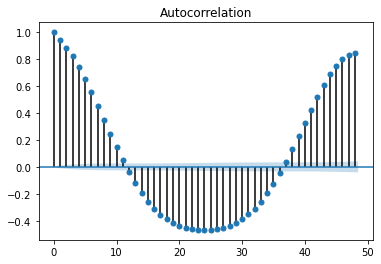

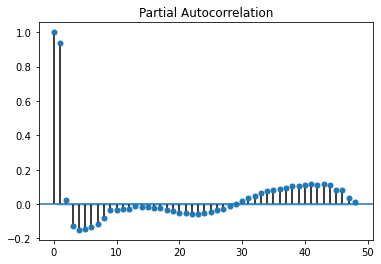

In [42]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
train
plot_acf(train['TARGET'])
plot_pacf(train['TARGET'])
plt.show()

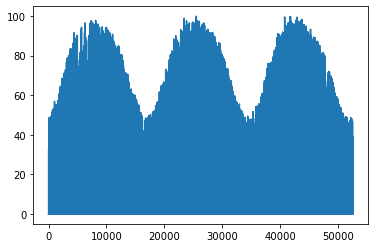

In [43]:
train['TARGET'].plot()